## Makemore pt3

In [1]:
import torch

In [2]:
import torch.nn.functional as F

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
words = open("names.txt", "r").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [6]:
len(words)

32033

In [7]:
# build vocab and mappings
chars = sorted(list(set(''.join(words))))
itos = {i+1:c for i,c in enumerate(chars)}
itos[0] = "."
stoi = {c:i for i,c in itos.items()}
vocab_size = len(stoi)
vocab_size

27

In [8]:
# build dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)

    return X, Y
            

In [9]:
# data splits
import random
random.seed(42)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

random.shuffle(words)


Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [31]:
# MLP revisited
n_embd = 10 # dimension of the characters embeddings
neurons_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),                       generator = g)
W1 = torch.randn((n_embd * block_size, neurons_hidden),     generator = g) * 0.02
b1 = torch.randn(neurons_hidden,                            generator = g) * 0.01
W2 = torch.randn((neurons_hidden, vocab_size),              generator = g) * 0.01
b2 = torch.randn(vocab_size,                                generator = g) * 0

bngain =  torch.ones((1, neurons_hidden))
bnbias = torch.zeros((1, neurons_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

Number of parameters: 12297


In [ ]:
# optimization
max_steps = 200000
batch_size = 32
lossi = list()

for i in range(max_steps):

    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bn = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(bn)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # gradient
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if (i % 10000) == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.log10().item())
    



      0/ 200000: 3.314689
  10000/ 200000: 2.154984
  20000/ 200000: 2.305854
  30000/ 200000: 2.416523
  40000/ 200000: 1.950499
  50000/ 200000: 2.292465
  60000/ 200000: 2.391149
  70000/ 200000: 2.087268
  80000/ 200000: 2.373348
  90000/ 200000: 2.159687
 100000/ 200000: 1.907540
 110000/ 200000: 2.391078
 120000/ 200000: 1.860608
 130000/ 200000: 2.463813
 140000/ 200000: 2.458199
 150000/ 200000: 2.355335
 160000/ 200000: 1.855891


In [ ]:
plt.plot(lossi)

In [27]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1399481296539307
val 2.1773862838745117


In [15]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10 )

num_names = 21
for _ in range(num_names):
    out = list()
    context = [0] * block_size
    while True:
        # forward pass
        emb = C[context]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1
        bn = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
        h = torch.tanh(bn)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()

        # shift context window
        context = context[1:] + [ix]

        # update new character
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carpaizamori.
kahlimreigelly.
skanyla.
jazon.
nadellari.
kaeli.
nellari.
chriha.
kaleigh.
ham.
join.
quinn.
salin.
alvin.
quin.
elon.
jarisi.
jaxek.
druan.
eddeco.
akette.


In [16]:
emb.view(1, -1)

tensor([[ 0.8660,  1.3616,  1.0285,  1.2456, -2.8291,  0.7561,  1.0798, -0.6981,
          0.3674, -1.2248,  0.8660,  1.3616,  1.0285,  1.2456, -2.8291,  0.7561,
          1.0798, -0.6981,  0.3674, -1.2248,  0.1842,  1.8567,  0.8110, -1.6495,
          0.3114, -0.9939,  1.0422,  0.6534, -1.1143, -1.5444]],
       grad_fn=<ViewBackward0>)

In [17]:
emb.view(emb.shape[0], -1).shape

torch.Size([3, 10])

In [19]:
emb.shape

torch.Size([3, 10])

## Problems with our previous implementation

### Fixing the initial loss
The first item of the loss is too high and then it stabilizes. That causes the loss plot to look like a hockey stick which gauges that the model is learning the bias only in the first iterations. 
- **Cause:** A poor initialization of the last layers wandb
- **Solution:** Scale `W1` by `0.01` and set `b2 = b2 * 0`

### Fixing saturated tanh
- If we see the values of `h` after the first iteration we see this
``` tensor([[-0.9620, -1.0000, -1.0000,  ..., -0.1601, -1.0000, -1.0000],
        [ 0.1131,  0.2711, -1.0000,  ..., -0.9979,  0.9930,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        ...,
        [-0.1424, -0.9988, -0.7355,  ..., -1.0000,  1.0000,  1.0000],
        [-0.9610,  0.7872, -0.9890,  ..., -1.0000,  0.9994,  1.0000],
        [-0.9620, -1.0000, -1.0000,  ..., -0.1601, -1.0000, -1.0000]],
       grad_fn=<TanhBackward0>)
```

- If wee see the values of `h` in a histogram we get this


(array([ 625.,   80.,   55.,   50.,   49.,   32.,   22.,   25.,   31.,
          24.,   45.,   30.,   20.,   20.,   11.,   22.,   22.,   28.,
          34.,   58.,   51.,   90.,  192.,  378., 1102., 1073.,  422.,
         141.,  118.,   59.,   52.,   38.,   59.,   35.,   45.,   22.,
          30.,   18.,   18.,   33.,   41.,   30.,   22.,   30.,   46.,
          49.,   45.,   83.,   98.,  697.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

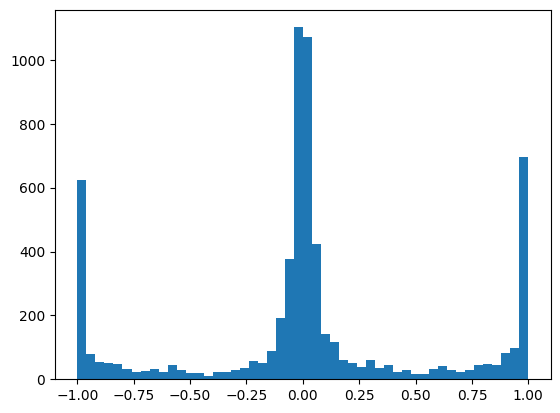

In [28]:
plt.hist(h.view(-1).tolist(), 50)

That histograms tells us that this `tanh` function is very active (extreme values are more frequent ones). We can see why is that seeing the preactivations of `h`

In [29]:
hpreact = emb.view(-1, block_size * n_embd) @ W1 + b1

(array([1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 1.000e+00, 2.000e+00, 4.000e+00, 8.000e+00, 7.000e+00,
        1.100e+01, 2.000e+01, 2.600e+01, 2.300e+01, 3.700e+01, 5.600e+01,
        6.200e+01, 9.100e+01, 9.400e+01, 1.020e+02, 1.260e+02, 1.200e+02,
        1.690e+02, 2.370e+02, 3.733e+03, 3.310e+02, 2.040e+02, 1.710e+02,
        1.310e+02, 1.160e+02, 1.060e+02, 8.200e+01, 5.000e+01, 3.400e+01,
        5.000e+01, 3.900e+01, 3.000e+01, 2.700e+01, 2.200e+01, 1.700e+01,
        6.000e+00, 1.900e+01, 5.000e+00, 3.000e+00, 1.100e+01, 6.000e+00,
        3.000e+00, 2.000e+00]),
 array([-13.06392956, -12.57200649, -12.08008343, -11.58816036,
        -11.0962373 , -10.60431423, -10.11239117,  -9.6204681 ,
         -9.12854504,  -8.63662197,  -8.14469891,  -7.65277584,
         -7.16085278,  -6.66892971,  -6.17700665,  -5.68508358,
         -5.19316051,  -4.70123745,  -4.20931438,  -3.71739132,
         -3.22546825,  -2.73354519,  -2.24162212,  -1.74

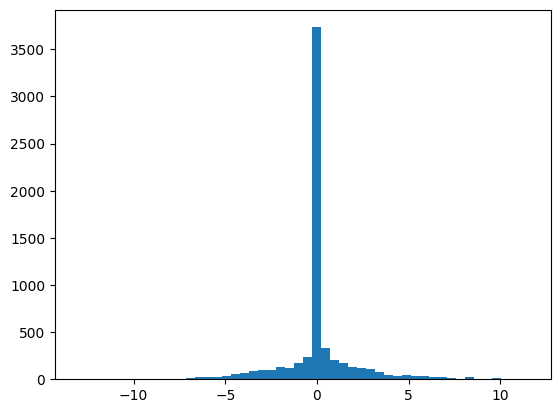

In [30]:
plt.hist(hpreact.view(-1).tolist(), 50)

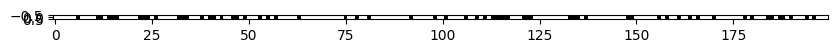

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

The previous map shows the specific neurons that are saturating the activation function, tanh. 200 neurons and 32 logits (output). If we see a lot of white cells it means the model is not learning because information is lost in the activation.
- **Cause:** Initialization of `W1` and `b1` weights.
- **Solution:** Scaling initial weights by `0.01`

## Kaiming init
Kaiming He et al propose a method for initializing the initial weights using a factor that prevents data spreading or getting to narrow by keeping the standard deviation the same.
This is done by multiplying my $\text{std} = \frac{\text{gain}}{\sqrt{\text{fan\_in}}}$ where $\text{gain}$ is a related to the activation function (for tanh is 5/3); and $\text{fan\_in}$ is the number of input features in the model

`W1 = torch.randn((n_embd * block_size, neurons_hidden),     generator = g) * (5/3) / (n_embd * block_size)*1/2`

This is equivalent to using the `torch` function
```
torch.nn.init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu', generator=None)
```

In [78]:
(5/3) / (n_embd * block_size)*1/2 # similar to what andrej suggested before

0.02777777777777778

## Batch normalization
Make the neurons activations roughly normal by 
1. Taking the mean of the batch pre-activations $\mu_\mathcal{B}$
2. Taking the variance of the batch $\sigma_{\mathcal{B}}^2$
3. And normalizing:  $\hat{x} = \frac{x-\mu_\mathcal{B}}{\sigma}$

Also, this normalization can change through out training. This can be done by shifting and scaling:
$$y = \gamma \hat{x} + \beta$$

That can be done by adding this line 
```
bn = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
```